### Model: 

[Phenotypic Diversity, Population Growthn and Information in Fluctuating Enviroments, Edo Kussell and Stanislas Leiber]

$$
\Large 
x'(t) = A_{\epsilon(t)} x(t)
$$

where $\epsilon(t)$ is a stochastic process and  

$$
\Large
A_k = 
\begin{bmatrix}
f_1^{(k)} - H_{11} & H_{23} & H_{13} \\
 H_{21} & f_2^{(k)} - H_{22} & H_{23} \\
 H_{31} & H_{32} & f_3^{(k)} - H_{33}
\end{bmatrix}
$$


In the matrix, $f_j^{(k)}$ is the growth rate of phenotype $j$ in enviroment $k$. 


### Goal: 

Study the distribution of $x_j(t)$.

### Idea: 

The Lyapunov exponent of the model has an expansion with terms that are similar to the boosting algo. 

In [1]:
import numpy as np
from functools import partial
import matplotlib.pylab as plt

In [2]:
from scipy import linalg
from scipy.integrate import solve_ivp
import scipy

In [3]:
def next_enviroment(intitial_env, Q):
    '''
    Given an initial state, computes the next state in a markov chain with transition matrix Q. 
    '''
    sample = np.random.multinomial(1, Q[intitial_env], size = 1)
    next_env = np.argmax(sample)
    return(next_env)

In [4]:
def Aeps_x(t, x, enviroment, Q, F, H):
    
    '''
    inputs: 
        - t = time.
        - x[j] = # of cells with phenotype j in an enviroment. 
        - enviroment = number of enviroment. There are E in total.  
        - Q = ExE transition matrix of a Markov Chain.  
        - F = ExP matrix with growth rate of phenotypes for each enviroment. 
        - H = PxP matrix with the switching rates from phenotype i to j.
    '''
    E = Q.shape[0]
    P = F.shape[1]

    A = np.diag(F[enviroment]) - H
    
    dx = A.dot(x)
    
    return(dx)

# A 2x2 Example 

In [5]:
EMat = np.array([[10, 5], 
                 [5, 10]])

# number of enviroments and phenotypes
E = 2
P = 2

row_sums = EMat.sum(axis=1).reshape(E, 1)
Q = EMat / row_sums

H = np.array([[0, 0.05],
              [1e-6, 0]])

F = np.array([[2, 0], 
              [0, 2]]) 

In [32]:
N = 1000
tfinal = 25
t0 = 0
t = np.linspace(start=0, stop=tfinal, num=N)
x0 = [20, 20]
e0 = 0

In [33]:
def solvSYS(e0, Q, F, H, N, x0, t0, tfinal):
    
    solver = scipy.integrate.ode(Aeps_x).set_integrator('dopri5', nsteps=100)
    solver.set_initial_value(x0, t0).set_f_params(e0, Q, F, H)

    sol = np.zeros((N, E))
    sol[0] = x0
    Enviroments = np.zeros(N)

    k = 1
    while solver.successful() and solver.t < tfinal:
        solver.integrate(t[k])
        sol[k] = solver.y
        k += 1

        Enviroments[k-1] = e0

        e0 =  next_enviroment(e0, Q=Q)
        solver.set_f_params(e0, Q, F, H)
    
    return(sol, Enviroments)

In [34]:
sol, Enviroments = solvSYS(e0, Q, F, H, N, x0, t0, tfinal)

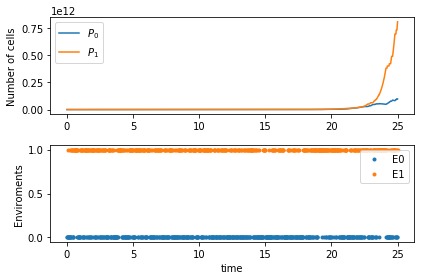

In [35]:
plt.subplot(211)
plt.plot(t, sol[:,0], label='$P_0$')
plt.plot(t, sol[:,1], label='$P_1$')
plt.ylabel('Number of cells')
plt.legend()


E0 = np.copy(Enviroments)
E1 = np.copy(Enviroments)
E0[Enviroments == 1] = np.nan
E1[Enviroments == 0] = np.nan

plt.subplot(212)
plt.plot(t, E0, '.', label = 'E0')
plt.plot(t, E1, '.', label = 'E1')
plt.ylabel('Enviroments')
plt.xlabel('time')
plt.legend()

plt.tight_layout()
plt.savefig('twoPhenotypes.png', format='png', dpi=500)
plt.show()